<a href="https://colab.research.google.com/github/sid0312/10DaysMLChallenge/blob/master/maize_desnet101_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!curl -s https://course.fast.ai/setup/colab | bash
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai import *
from fastai.imports import *
import torchvision

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [3]:
path = Path('/content/drive/My Drive/research_plant_diseases/maize_data_fastai')
# View all files in director
path.ls()
transforms = get_transforms(
    do_flip=True, 
    flip_vert=True, 
    max_rotate=15.0, 
    max_lighting=0.15, 
    max_warp=0.2,
    xtra_tfms= [ 
                jitter(magnitude=0.03)]
)

In [4]:
labels=[]
import os
test_path = '/content/drive/My Drive/research_plant_diseases/maize_data_fastai/test'
l=[]
for i in os.listdir(test_path):
  l.append(os.path.join(test_path,i))
l
test_imgs1 = (path/l[0]).ls()
for i in range(len(test_imgs1)):
  labels.append('Corn_(maize)___Common_rust_')
test_imgs2 = (path/l[1]).ls()
for i in range(len(test_imgs2)):
  labels.append('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot')
test_imgs3 = (path/l[2]).ls()
for i in range(len(test_imgs3)):
  labels.append('Corn_(maize)___healthy')
test_imgs4 = (path/l[3]).ls()
for i in range(len(test_imgs4)):
  labels.append('Corn_(maize)___Northern_Leaf_Blight')
test_df = pd.DataFrame(columns=['ImageList','CategoryList'])
test_imgs = test_imgs1+test_imgs2+test_imgs3+test_imgs4
test_df['ImageList'] = test_imgs
test_df['CategoryList'] = labels


In [5]:
d = {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 1,
 'Corn_(maize)___Common_rust_': 0,
 'Corn_(maize)___Northern_Leaf_Blight': 3,
 'Corn_(maize)___healthy': 2}
classes = []
for x in labels:
  classes.append(d[x])
test_df['classes'] = classes
test_df.head()

,ImageList,CategoryList,classes
0,/content/drive/My Drive/research_plant_disease...,Corn_(maize)___Common_rust_,0
1,/content/drive/My Drive/research_plant_disease...,Corn_(maize)___Common_rust_,0
2,/content/drive/My Drive/research_plant_disease...,Corn_(maize)___Common_rust_,0
3,/content/drive/My Drive/research_plant_disease...,Corn_(maize)___Common_rust_,0
4,/content/drive/My Drive/research_plant_disease...,Corn_(maize)___Common_rust_,0


In [6]:
data = ImageDataBunch.from_folder(path, train='train', valid='val', ds_tfms=transforms, size=256, bs=50, num_workers=4)


In [9]:
import torchvision
learn = cnn_learner(data, torchvision.models.densenet121, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [10]:
data.add_test(test_imgs)

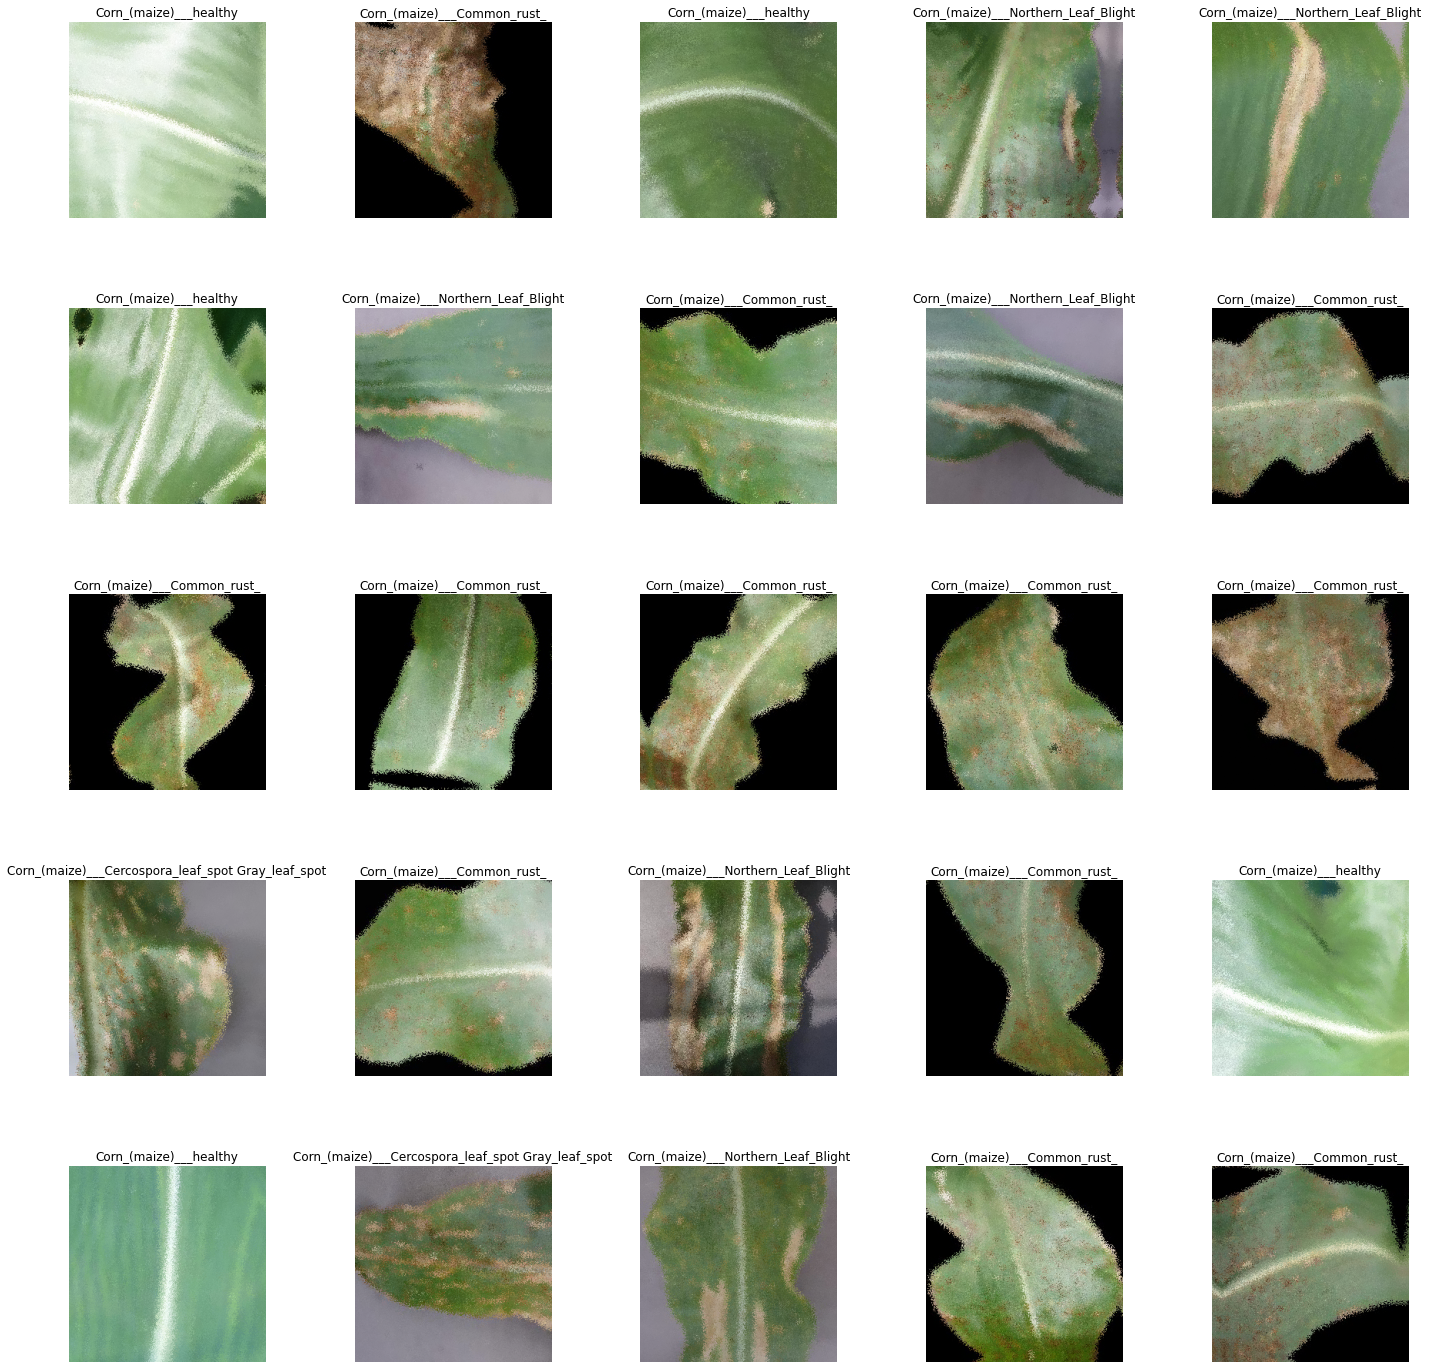

In [11]:
data.show_batch()

In [12]:
import torch
torch.cuda.empty_cache()
import warnings
warnings.filterwarnings('ignore')
defaults.device = torch.device('cuda') 

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-04
Min loss divided by 10: 8.32E-03


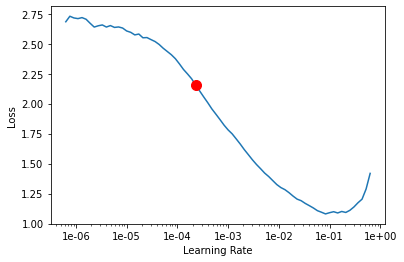

In [14]:
learn.recorder.plot(suggestion="true")

In [15]:
olr = learn.recorder.min_grad_lr
olr
learn.fit_one_cycle(5,slice(olr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.144732,0.397308,0.148438,0.851562,01:34
1,0.516098,0.229170,0.085938,0.914062,00:47
2,0.301881,0.201860,0.075521,0.924479,00:47
3,0.249891,0.195631,0.075521,0.924479,00:47
4,0.210162,0.194183,0.072917,0.927083,00:47


In [18]:
def train_tune(limit=5,epochs=5):
  olrs = []
  for i in range(limit):
    learn.lr_find()
    learn.recorder.plot(suggestion=True,return_fig=False)
    olr = learn.recorder.min_grad_lr
    olrs.append(olr)
    learn.fit_one_cycle(epochs,slice(olr))

  return learn, olrs

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.20E-06


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.188590,0.190744,0.072917,0.927083,00:47
1,0.191338,0.197804,0.080729,0.919271,00:47
2,0.197941,0.194638,0.072917,0.927083,00:48
3,0.201561,0.204507,0.083333,0.916667,00:48
4,0.193010,0.192619,0.072917,0.927083,00:49


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 9.12E-08


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.187830,0.193015,0.072917,0.927083,00:48
1,0.204062,0.186897,0.072917,0.927083,00:48
2,0.203362,0.191805,0.070313,0.929688,00:48
3,0.199040,0.188446,0.072917,0.927083,00:47
4,0.194829,0.192567,0.078125,0.921875,00:48


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.37E-04


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.192273,0.194771,0.075521,0.924479,00:47
1,0.194440,0.184944,0.072917,0.927083,00:48
2,0.185072,0.191619,0.075521,0.924479,00:48
3,0.193989,0.194816,0.072917,0.927083,00:48
4,0.189469,0.187242,0.072917,0.927083,00:47


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.20E-04


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.198052,0.197087,0.072917,0.927083,00:47
1,0.194773,0.194270,0.072917,0.927083,00:47
2,0.195605,0.185882,0.067708,0.932292,00:47
3,0.202113,0.200124,0.080729,0.919271,00:47
4,0.206650,0.195023,0.070313,0.929688,00:47


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.00E-06


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.203177,0.190452,0.070313,0.929688,00:47
1,0.190321,0.190103,0.070313,0.929688,00:47
2,0.182676,0.189875,0.072917,0.927083,00:47
3,0.192444,0.191871,0.075521,0.924479,00:47
4,0.196765,0.192272,0.072917,0.927083,00:46


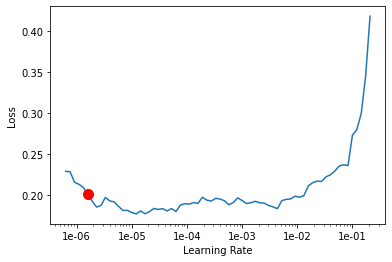

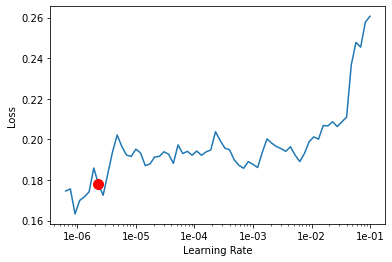

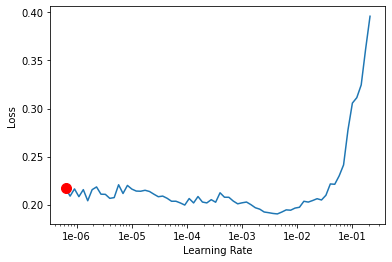

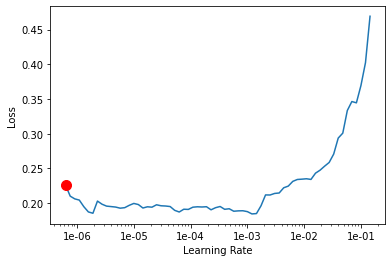

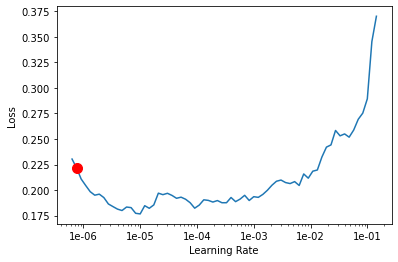

In [19]:
learn, olrs = train_tune()

In [20]:
print(olrs)

[1.5848931924611132e-06, 2.2908676527677735e-06, 6.309573444801933e-07, 6.309573444801933e-07, 7.585775750291837e-07]


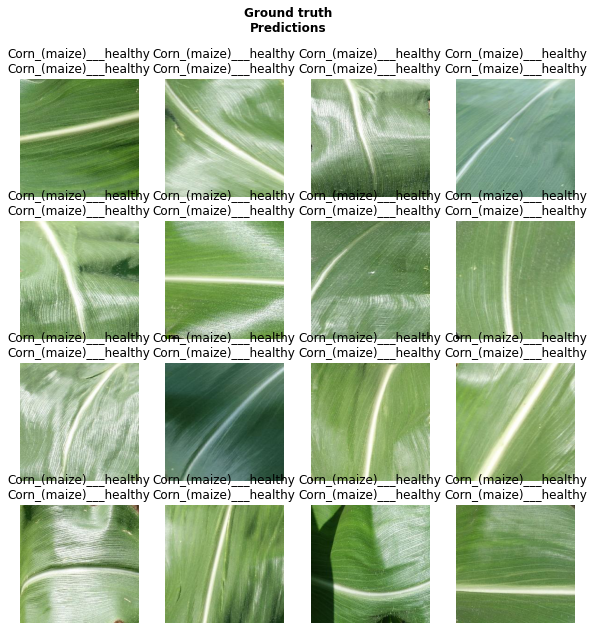

In [21]:
learn.show_results(rows=4, figsize=(10,10))
learn.save('densenet121')
data_diagrams_densenet121= ClassificationInterpretation.from_learner(learn)

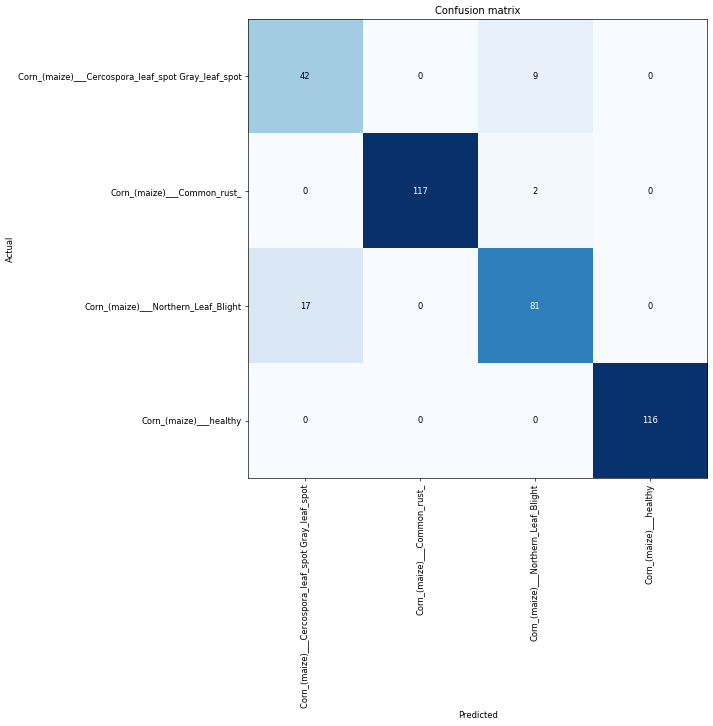

In [22]:
data_diagrams_densenet121.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
data_diagrams_densenet121.most_confused()

[('Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  17),
 ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn_(maize)___Northern_Leaf_Blight',
  9),
 ('Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 2)]

In [24]:
log_preds, y = learn.TTA()
accuracy(log_preds, y)

tensor(0.9479)

In [25]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(log_preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 1.0


In [26]:
learn.validate(data.valid_dl)

[0.19227165, tensor(0.0729), tensor(0.9271)]

In [27]:
pred = log_preds.numpy()
y_pred = []
for i in pred:
  y_pred.append(np.argmax(i))
y_actual = y.numpy()
y_actual = list(y_actual)
from sklearn.metrics import classification_report
print(classification_report(y_actual,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82        51
           1       1.00      0.98      0.99       119
           2       0.90      0.91      0.90        98
           3       1.00      1.00      1.00       116

    accuracy                           0.95       384
   macro avg       0.93      0.93      0.93       384
weighted avg       0.95      0.95      0.95       384



In [28]:
from sklearn.metrics import recall_score,precision_score,f1_score
print("Recall = ",recall_score(y_actual,y_pred,average='weighted'))
print("Precision = ",precision_score(y_actual,y_pred,average='weighted'))
print("F1 score = ",f1_score(y_actual,y_pred,average='weighted'))

Recall =  0.9479166666666666
Precision =  0.9486805150867651
F1 score =  0.9482603692283629


In [29]:
data.add_test(test_imgs)
preds = learn.get_preds(ds_type=DatasetType.Test)
y_pred = np.argmax(preds[0], axis = 1)
preds_classes = [data.classes[i] for i in y_pred]
y_preds = [d[i] for i in preds_classes]
y_actual = test_df['classes']

In [31]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, recall_score,precision_score,f1_score
print(classification_report(y_actual,y_preds))
print("Recall = ",recall_score(y_actual,y_preds,average='weighted'))
print("Precision = ",precision_score(y_actual,y_preds,average='weighted'))
print("F1 score = ",f1_score(y_actual,y_preds,average='weighted'))
print(confusion_matrix(y_actual,y_preds))
from sklearn.metrics import accuracy_score
accuracy_score(y_actual,y_preds)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       0.69      0.65      0.67        52
           2       0.99      1.00      1.00       117
           3       0.83      0.85      0.84        99

    accuracy                           0.91       388
   macro avg       0.88      0.88      0.88       388
weighted avg       0.91      0.91      0.91       388

Recall =  0.9149484536082474
Precision =  0.9134709816822133
F1 score =  0.9141031666228698
[[120   0   0   0]
 [  0  34   1  17]
 [  0   0 117   0]
 [  0  15   0  84]]


0.9149484536082474